In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk

from nltk.sentiment import SentimentIntensityAnalyzer
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator

from textblob import TextBlob

from utils import stop_words, make_corpus_df, get_data_between_dates, get_data_by_year, get_data_by_channel, make_list_of_processed_snippets, NETWORKS, STATIONS

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dylanlewis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/dylanlewis/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/dylanlewis/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## We start the sentiment and subjectivity analysis on the entire dataset by analyzing differences between the networks.

Using the TextBlob NLP python package, we use a pre-trained Naive Bayes Classifiers which provides a score on our snippets between $[-1, 1]$ for sentiment (negative < 0, neutral = 0, positive > 0) and $[0, 1]$ for subjectivity, respectively. 

Using the sentiment scores from the sentiment classifier, we classify the snippet as being negative if the score < -0.25, neutral if 0.25 >= score >= -0.25, and finally as positive if score > 0.25. To reduce the amount of signals of weak polarity, we extend the boundaries for neutral sentiment from $[0, 0]$ to $[-0.25, 0.25]$, which increases the amount of neutral snippets and reduces both positive and negative snippets to only those with strong polarity, which is what we're utimately interested in analyzing.

Similarly, using the subjectivity scores from the subjectivity classifier, we classify a snippet as objective if the score < 0.5 and subjective if the score >= 0.5.

In [2]:
PARENT = 'TelevisionNewsV2'

In [3]:
def polarity_classification(sentiment_score):
    if sentiment_score > 0.25:
        return 'positive'
    elif -0.25 <= sentiment_score <= 0.25:
        return 'neutral'
    else:
        return 'negative'

def subjectivity_classificiation(subjectivity_score):
    if subjectivity_score >= 0.5:
        return 'subjective'
    else:
        return 'objective'

In [4]:
corpus_df = make_corpus_df(PARENT)
corpus_df = corpus_df[['DateTime', 'Station', 'Show', 'IAShowID', 'Snippet']]
unprocessed_corpus_df = corpus_df.copy()
corpus_df['Snippet'] = make_list_of_processed_snippets(corpus_df, stop_words)
corpus_df['polarity'] = corpus_df.apply(lambda row: TextBlob(row['Snippet']).polarity, axis=1)
corpus_df['subjectivity'] = corpus_df.apply(lambda row: TextBlob(row['Snippet']).subjectivity, axis=1)
corpus_df['sentiment_class'] = corpus_df.apply(lambda row: polarity_classification(row['polarity']), axis=1)
corpus_df['subjectivity_class'] = corpus_df.apply(lambda row: subjectivity_classificiation(row['subjectivity']), axis=1)

In [5]:
_2019_data = get_data_by_year(corpus_df, 2019)
_2020_data = get_data_by_year(corpus_df, 2020)
final_years_df = pd.concat([_2019_data, _2020_data])
years = [str(i) for i in range(2009, 2019)]
years.append("19+20")

In [6]:
cnn_df, fox_df, msnbc_df = get_data_by_channel(corpus_df, 'CNN'), get_data_by_channel(corpus_df, 'FOXNEWS'), get_data_by_channel(corpus_df, 'MSNBC')

In [7]:
cnn_sentiment_counts = cnn_df['sentiment_class'].value_counts()
fox_sentiment_counts = fox_df['sentiment_class'].value_counts()
msnbc_sentiment_counts = msnbc_df['sentiment_class'].value_counts()

cnn_subjectivity_counts = cnn_df['subjectivity_class'].value_counts()
fox_subjectivity_counts = fox_df['subjectivity_class'].value_counts()
msnbc_subjectivity_counts = msnbc_df['subjectivity_class'].value_counts()

In [8]:
list_sentiment_counts = [cnn_sentiment_counts, fox_sentiment_counts, msnbc_sentiment_counts]
positive_counts = [i['positive'] for i in list_sentiment_counts]
neutral_counts = [i['neutral'] for i in list_sentiment_counts]
negative_counts = [i['negative'] for i in list_sentiment_counts]

list_subjectivity_counts = [cnn_subjectivity_counts, fox_subjectivity_counts, msnbc_subjectivity_counts]
objective_counts = [i['objective'] for i in list_subjectivity_counts]
subjective_counts = [i['subjective'] for i in list_subjectivity_counts]

### Sentiment Analysis
We begin our sentiment analysis module by breaking up the entire corpus by TV network (i.e. CNN, Fox News, MSNBC). We are interested in understanding the sentiment polarity and subjectivity surrounding climate change discussion based on TV network. We note that there are more snippets for Fox News and MSNBC than CNN, so we use the ratio of the number of positive sentiment snippets / negative sentiment snippets to compare them appropriately. We use a pre-trained Naive Bayes Classifier offered by the TextBlob NLP Python package to classify the snippets across the entire corpus into Positive, Neutral, and Negative classes. We find the respective Positive/Negative ratios to be: CNN: 3.577;  Fox News: 2.417; MSNBC: 3.344. Our main finding from this is that across the networks, Fox News had the lowest positive / negative ratio indicating that as a network, they had relatively the most negative commentary surrounding climate change topics. 

In [9]:
cnn_pos_neg_ratio = cnn_sentiment_counts['positive'] / cnn_sentiment_counts['negative']
print('CNN Positive / Negative Ratio: ', cnn_pos_neg_ratio)
fox_pos_neg_ratio = fox_sentiment_counts['positive'] / fox_sentiment_counts['negative']
print('Fox Positive / Negative Ratio: ', fox_pos_neg_ratio)
msnbc_pos_neg_ratio = msnbc_sentiment_counts['positive'] / msnbc_sentiment_counts['negative']
print('MSNBC Positive / Negative Ratio: ', msnbc_pos_neg_ratio)

CNN Positive / Negative Ratio:  3.578301886792453
Fox Positive / Negative Ratio:  2.417391304347826
MSNBC Positive / Negative Ratio:  3.3443271767810026


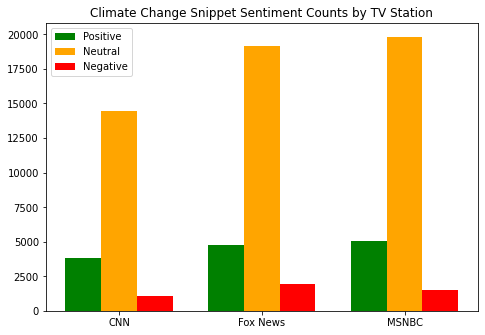

In [13]:
X = np.arange(3)

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
width = 0.25

ax.bar(X + 0*width, positive_counts, color='g', width=width, label="Positive")
ax.bar(X + 1*width, neutral_counts, color='orange', width=width, label="Neutral")
ax.bar(X + 2*width, negative_counts, color='r', width=width, label="Negative")
ax.set_title("Climate Change Snippet Sentiment Counts by TV Station")
ax.set_xticks(X + width)
ax.set_xticklabels(STATIONS)
ax.legend()
plt.show()

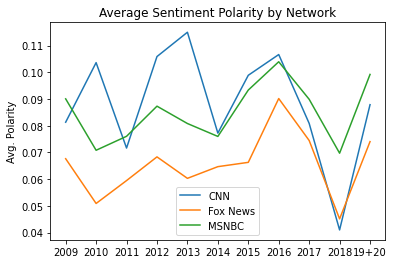

In [14]:
for i, network in enumerate(STATIONS):
    network_avg_polarity_over_time = [get_data_by_channel(get_data_by_year(corpus_df, year), NETWORKS[i])['polarity'].mean() for year in range(2009, 2019)]
    network_avg_polarity_over_time.append(get_data_by_channel(final_years_df, NETWORKS[i])['polarity'].mean())
    plt.plot(years, network_avg_polarity_over_time, label=network)
plt.title("Average Sentiment Polarity by Network")
plt.ylabel("Avg. Polarity")
plt.legend()
plt.show()

### Subjectivity
Additionally, we used a pre-trained Naive Bayes subjectivity classifier also provided by TextBlob to classify the snippets as being in objective or subjective classes. We report the Objective / Subjective ratios for each of the networks across the entire corpus: 
CNN: 1.331;  Fox News: 1.417; MSNBC: 1.439. The difference between these ratios isn’t as large as was the case with sentiment, but we notice the ratio of objective snippets / subjective snippets is lower for CNN than it is for Fox News and MSNBC suggesting that CNN has relatively more subjective snippets than the other networks

In [15]:
cnn_obj_subj_ratio = cnn_subjectivity_counts['objective'] / cnn_subjectivity_counts['subjective']
print('CNN Obj / Subj Ratio: ', cnn_obj_subj_ratio)
fox_obj_subj_ratio = fox_subjectivity_counts['objective'] / fox_subjectivity_counts['subjective']
print('Fox Obj / Subj Ratio: ', fox_obj_subj_ratio)
msnbc_obj_subj_ratio = msnbc_subjectivity_counts['objective'] / msnbc_subjectivity_counts['subjective']
print('MSNBC Obj / Subj Ratio: ', msnbc_obj_subj_ratio)

CNN Obj / Subj Ratio:  1.3305565616322588
Fox Obj / Subj Ratio:  1.4166121648136036
MSNBC Obj / Subj Ratio:  1.4396750669251361


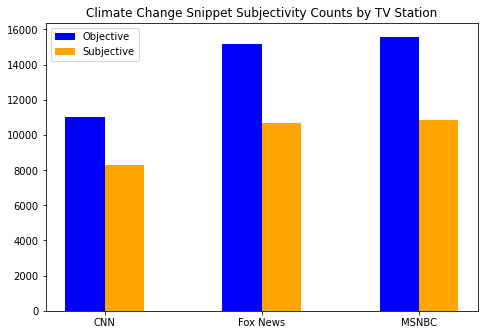

In [16]:
X = np.arange(3)

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
width = 0.25

ax.bar(X + 0*width, objective_counts, color='blue', width=width, label="Objective")
ax.bar(X + 1*width, subjective_counts, color='orange', width=width, label="Subjective")
ax.set_title("Climate Change Snippet Subjectivity Counts by TV Station")
ax.set_xticks(X + width/2)
ax.set_xticklabels(STATIONS)
ax.legend()
plt.show()

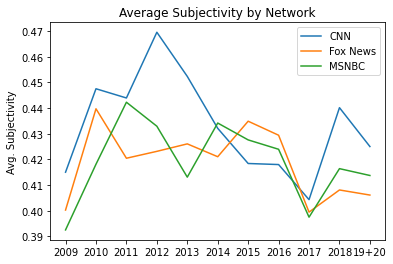

In [17]:
for i, network in enumerate(STATIONS):
    network_avg_subjectivity_over_time = [get_data_by_channel(get_data_by_year(corpus_df, year), NETWORKS[i])['subjectivity'].mean() for year in range(2009, 2019)]
    network_avg_subjectivity_over_time.append(get_data_by_channel(final_years_df, NETWORKS[i])['subjectivity'].mean())
    plt.plot(years, network_avg_subjectivity_over_time, label=network)
plt.title("Average Subjectivity by Network")
plt.ylabel("Avg. Subjectivity")
plt.legend()
plt.show()